# 03 Portfolio Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
#import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
import sys
sys.path.append('../')
sys.path.append('../../../../kungfu/')
import kungfu as kf

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
%matplotlib inline

In [6]:
#sns.set()
#sns.set(rc={'figure.figsize': (17, 6)})

In [7]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [17, 8]
#plt.rcParams['figure.dpi'] = 80

## Load data

In [8]:
return_matrix = pd.read_csv('../../../data/processed/return_matrix.csv').set_index('date')
return_matrix.index = pd.to_datetime(return_matrix.index, yearfirst=True)
return_matrix.columns.name = 'permno'

In [9]:
df_ff_raw = pd.read_pickle('../../../data/raw/df_ff_raw.pkl')

### Prepare

In [10]:
df_portfolio = kf.FinancialDataFrame(return_matrix.unstack())
df_portfolio = df_portfolio.rename(columns={0: 'daily_return'})

In [11]:
inc = pd.read_csv('../../../data/external/IN_yearly.csv', header=None)
outg = pd.read_csv('../../../data/external/OUT_yearly.csv', header=None)
opt_dates = return_matrix.index[return_matrix.index.year != pd.Series(return_matrix.index.year).shift(-1)][1:-1]

inc.index = return_matrix.columns
inc.columns = opt_dates
inc = inc.stack().to_frame().rename(columns={0: 'incoming'})

outg.index = return_matrix.columns
outg.columns = opt_dates
outg = outg.stack().to_frame().rename(columns={0: 'outgoing'})

df_portfolio = df_portfolio\
                .merge(inc, how='left', left_index=True, right_on=['permno','date'])\
                .merge(outg, how='left', left_index=True, right_on=['permno','date'])

In [12]:
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)
df_ff_raw = df_ff_raw.set_index('date')
capm = kf.FactorModel(df_ff_raw['mktrf'])
ff3f = kf.FactorModel(df_ff_raw[['mktrf','smb','hml']])

## Sort

In [13]:
portfolios = df_portfolio.sort_portfolios(['daily_return'], ['incoming'], method='sequential', n_sorts=8, lag=1)

In [14]:
portfolios.summarise_performance(252)

,1,2,3,4,5,6,7,8
Return p.a. (arithmetic),0.1119,0.1305,0.1257,0.1331,0.1401,0.1441,0.1325,0.1395
Return p.a. (geometric),0.1080,0.1269,0.1164,0.1215,0.1250,0.1248,0.1057,0.0935
Volatility p.a.,0.1366,0.1483,0.1766,0.1921,0.2111,0.2299,0.2528,0.3169
Sharpe ratio,0.7910,0.8559,0.6589,0.6324,0.5920,0.5429,0.4182,0.2952
t-stat,3.4756,3.7318,3.0187,2.9384,2.8135,2.6575,2.2225,1.8672
Total return,5.3255,7.5669,6.2367,6.8559,7.3126,7.2910,5.0924,3.9920
Positive returns %,54.9106,54.8223,55.1755,54.0719,54.1602,53.7630,53.1891,52.9464
VaR 95% (historic),-0.0123,-0.0143,-0.0163,-0.0184,-0.0198,-0.0214,-0.0236,-0.0302
VaR 95% (parametric),-0.0137,-0.0148,-0.0178,-0.0194,-0.0213,-0.0233,-0.0257,-0.0323
Expected shortfall 95%,-0.0201,-0.0220,-0.0270,-0.0291,-0.0312,-0.0341,-0.0378,-0.0463


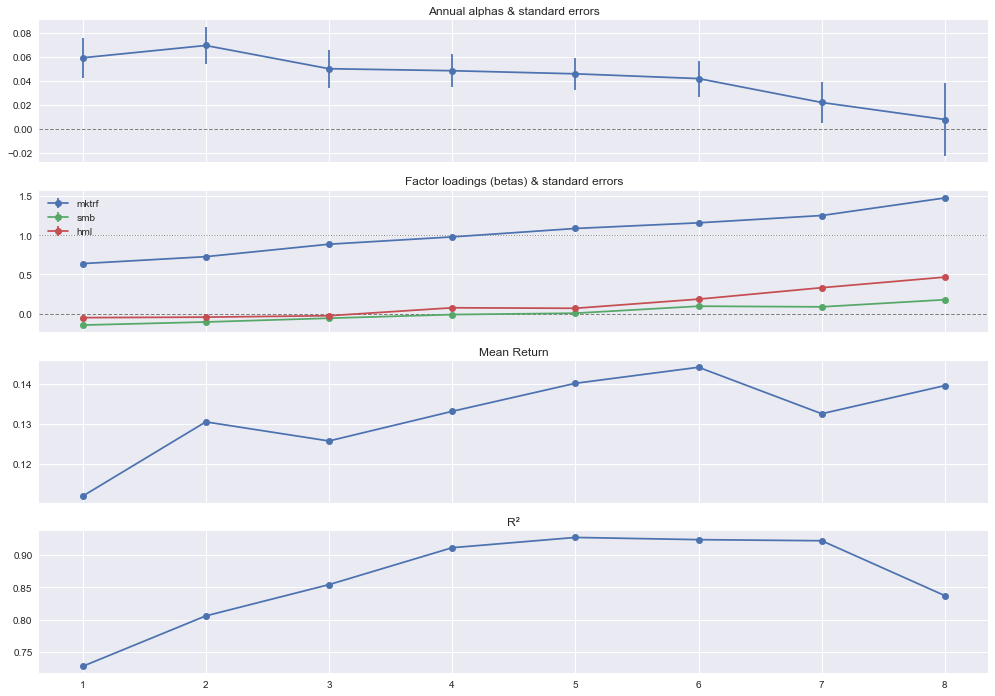

In [15]:
_ = ff3f.fit(portfolios.returns.unstack()).plot_results(252, figsize=[17,12])

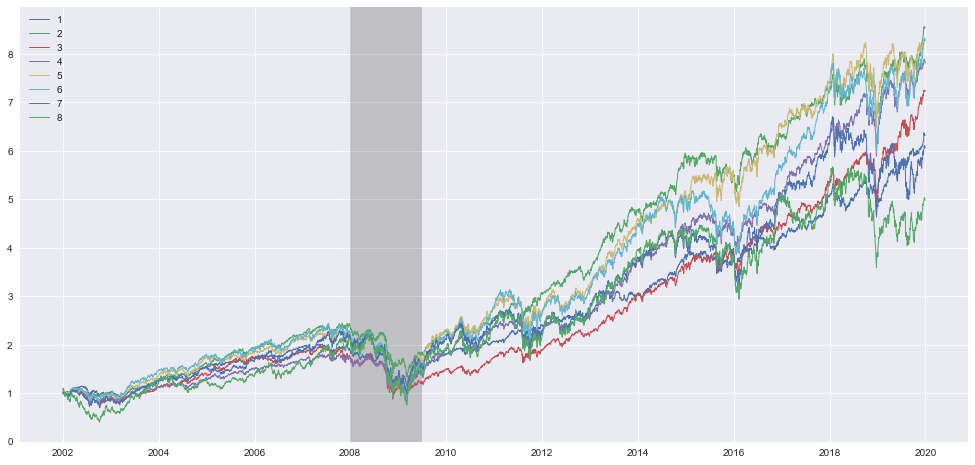

In [16]:
_ = portfolios.plot_indices()

## Indices

In [17]:
equal_index = kf.index.create_index(df_portfolio['daily_return'])
equal_index = equal_index[equal_index.index.year>=2002]
weighted_index = kf.index.create_index(df_portfolio['daily_return'], df_portfolio['incoming'], lag=1)

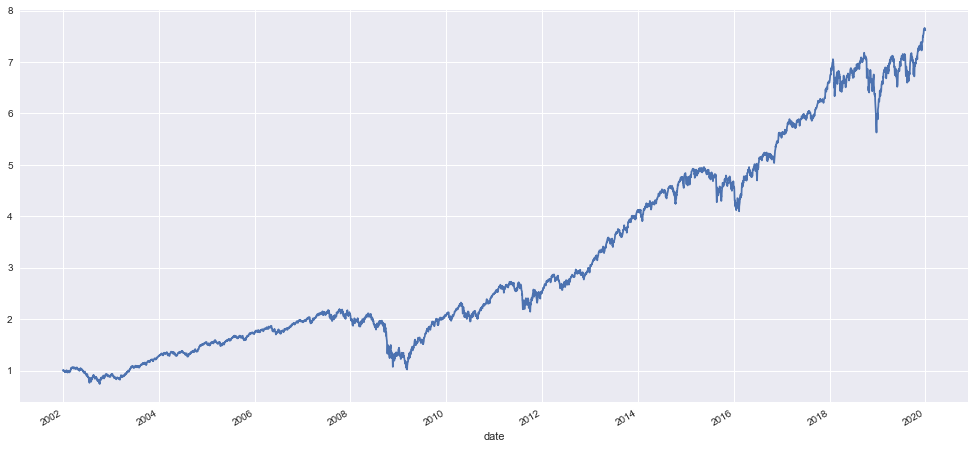

In [18]:
equal_index.to_prices().plot()

In [27]:
dta = df_portfolio['daily_return'].iloc[df_portfolio.index.get_level_values('date').year>=2002].swaplevel(0,1)
equal_pf = kf.portfolio.Portfolio(asset_returns=dta)
equal_pf = equal_pf.set_equal_weights().infer_prices().rebalance('continuous').infer_quantities()

In [28]:
equal_pf.merged_data

return    price  quantity  weight
date       permno                                   
2002-01-02 10104   0.0122   1.0122    0.0044  0.0045
           10107   0.0119   1.0119    0.0044  0.0045
           10138  -0.0061   0.9939    0.0045  0.0045
           10145  -0.0125   0.9875    0.0045  0.0045
           10516  -0.0126   0.9874    0.0045  0.0045
...                   ...      ...       ...     ...
2019-12-31 87432   0.0048   3.7506    0.0012  0.0045
           87447   0.0053   2.7044    0.0017  0.0045
           88031   0.0029 576.2658    0.0000  0.0045
           91556  -0.0008  27.3550    0.0002  0.0045
           92655   0.0004  15.4245    0.0003  0.0045

[1014944 rows x 4 columns]

In [23]:
equal_pf.quantities = equal_pf.weights

In [24]:
equal_pf.merged_data

return    price  quantity  weight
date       permno                                   
2002-01-02 10104   0.0122   1.0122    0.0045  0.0045
           10107   0.0119   1.0119    0.0045  0.0045
           10138  -0.0061   0.9939    0.0045  0.0045
           10145  -0.0125   0.9875    0.0045  0.0045
           10516  -0.0126   0.9874    0.0045  0.0045
...                   ...      ...       ...     ...
2019-12-31 87432   0.0048   3.7506    0.0045  0.0045
           87447   0.0053   2.7044    0.0045  0.0045
           88031   0.0029 576.2658    0.0045  0.0045
           91556  -0.0008  27.3550    0.0045  0.0045
           92655   0.0004  15.4245    0.0045  0.0045

[1014944 rows x 4 columns]

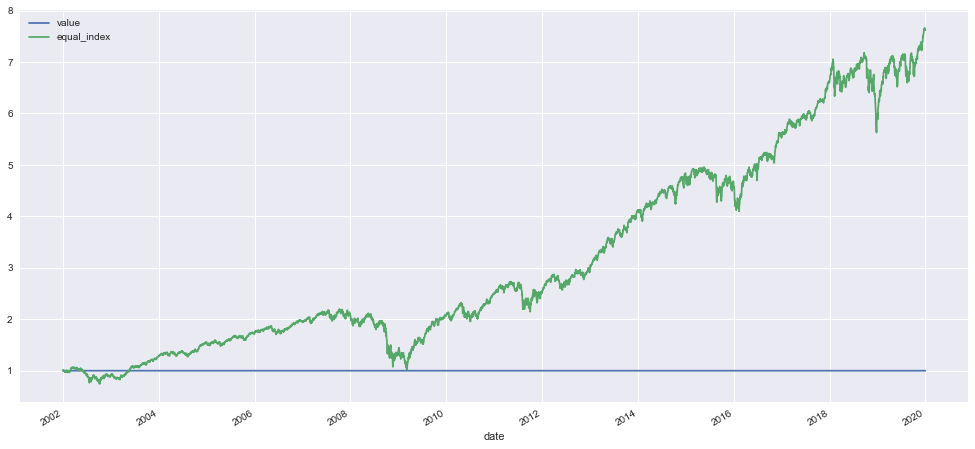

In [29]:
a = equal_pf.value#.returns.to_prices()
b = equal_index.to_prices()
a.to_frame().join(b).plot()

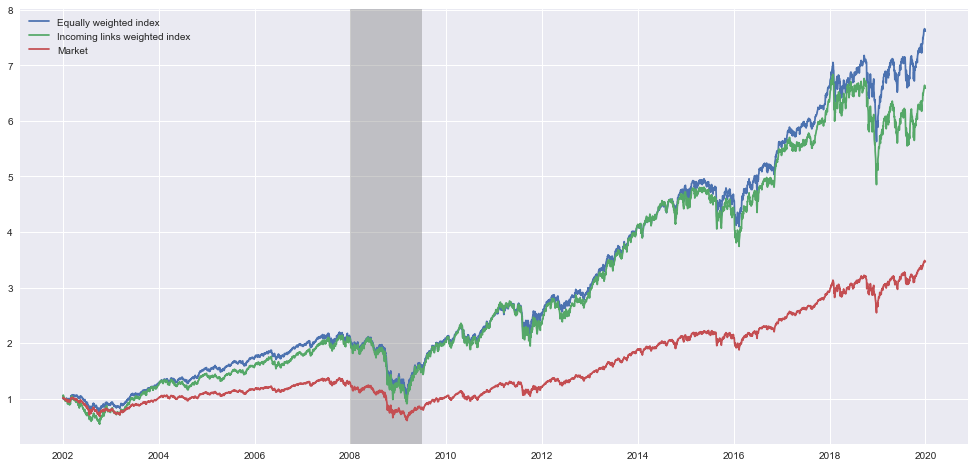

In [27]:
fig, ax = plt.subplots(1,1)

ax.plot(equal_index.to_prices(), label='Equally weighted index')
ax.plot(weighted_index.to_prices(), label='Incoming links weighted index')
ax.plot(kf.FinancialSeries(df_ff_raw['mktrf'][df_ff_raw.index.year >=2002]).set_obstype('return').to_prices(), label='Market')
ax.legend(loc='upper left')

startdate = equal_index.index[0]
enddate = equal_index.index[-1]
kf.add_recession_bars(ax, startdate=startdate, enddate=enddate)

plt.show()

In [20]:
equal_index.to_frame().join(weighted_index).summarise_performance(obstype='return', annual_obs=252)

,equal_index,weighted_index
Return p.a. (arithmetic),0.1322,0.1345
Return p.a. (geometric),0.1197,0.1108
Volatility p.a.,0.1953,0.2428
Sharpe ratio,0.6131,0.4562
t-stat,2.8703,2.3492
Total return,6.6395,5.6110
Positive returns %,54.9989,53.6526
VaR 95% (historic),-0.0182,-0.0238
VaR 95% (parametric),-0.0197,-0.0246
Expected shortfall 95%,-0.0294,-0.0363


## Factor Models

In [21]:
onefm_e = kf.FactorModel(equal_index)
onefm_w = kf.FactorModel(weighted_index)

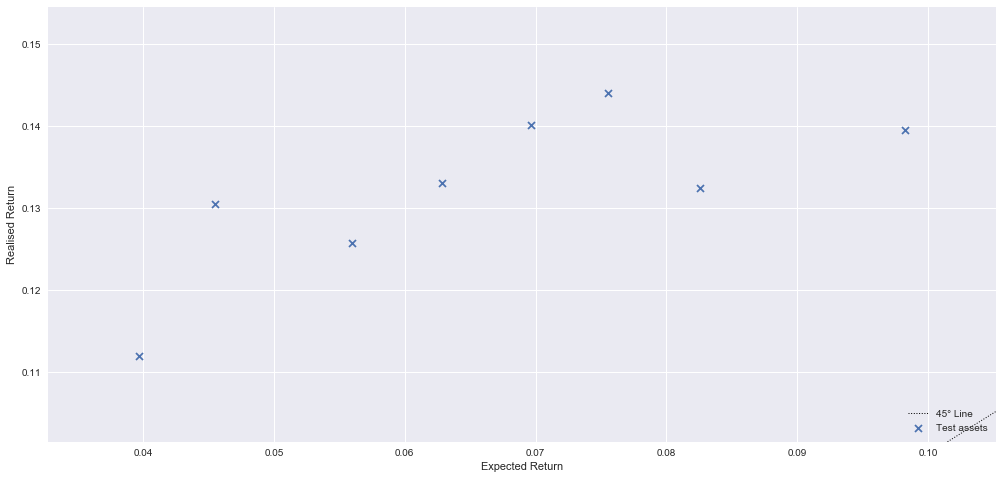

In [22]:
_ = capm.fit(portfolios.returns.unstack()).plot_predictions(252)

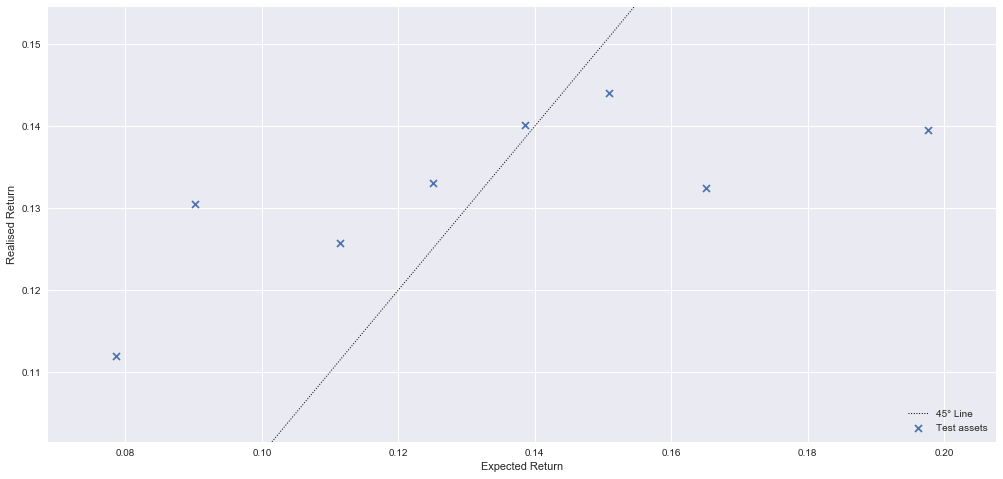

In [23]:
_ = onefm_e.fit(portfolios.returns.unstack()).plot_predictions(252)

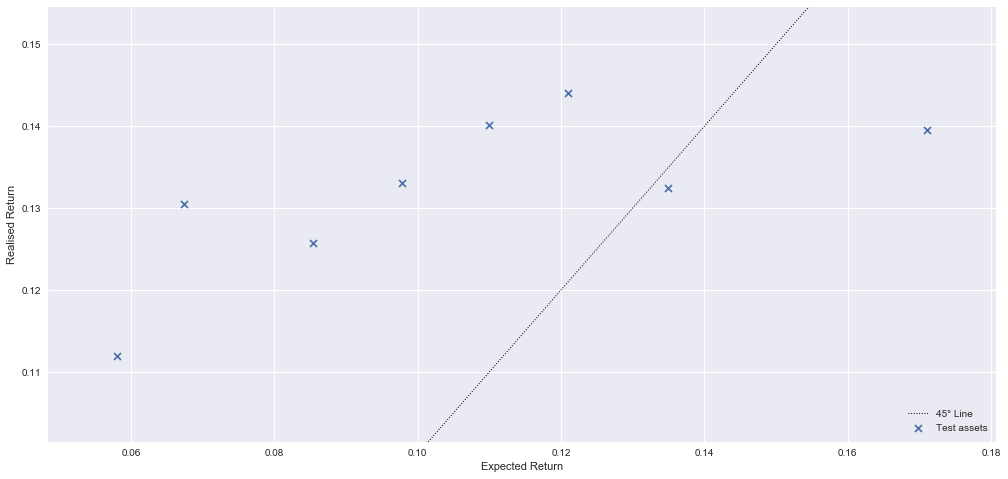

In [24]:
_ = onefm_w.fit(portfolios.returns.unstack()).plot_predictions(252)

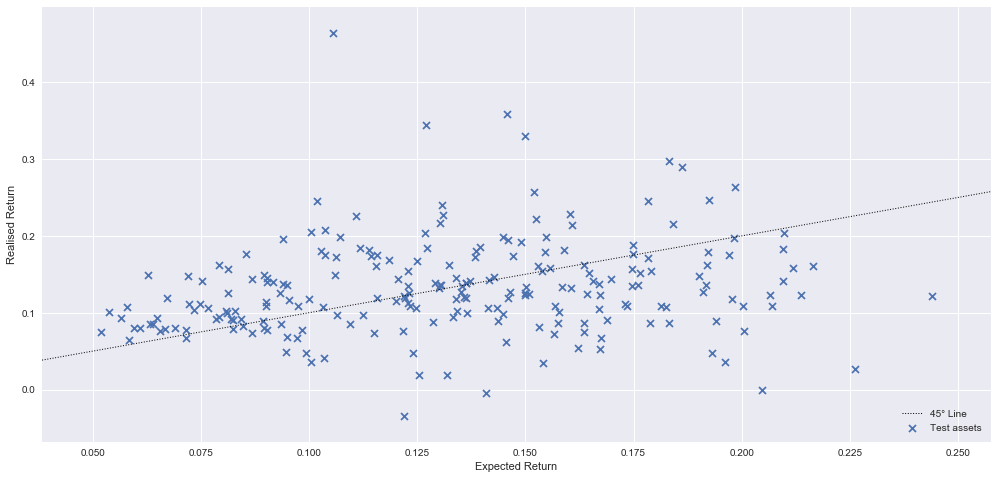

In [25]:
example = onefm_e.fit(return_matrix.iloc[500:]).plot_predictions(252)

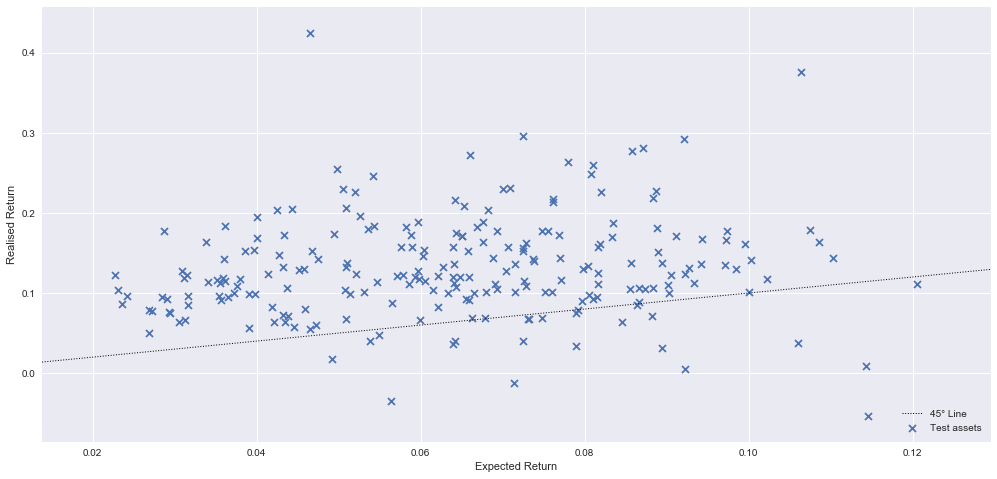

In [18]:
ex2 = capm.fit(return_matrix).plot_predictions(252)

In [26]:
onefm_e.calculate_grs_test(portfolios.returns.unstack())

(1.042709777459909, 0.40102680211333563)

In [27]:
onefm_w.calculate_grs_test(portfolios.returns.unstack())

(1.383381437766592, 0.19827450883593)

In [28]:
capm.calculate_grs_test(portfolios.returns.unstack())

(6.543596621049606, 1.622427370229218e-08)

In [23]:
portfolios.frequencies

,1,2,3,4,5,6,7,8
permno,,,,,,,,
10104,0,0,0,5,5,2,4,2
10107,0,4,3,4,1,3,3,0
10138,0,0,0,0,0,0,6,12
10145,0,0,0,1,2,7,8,0
10516,0,6,3,6,3,0,0,0
...,...,...,...,...,...,...,...,...
87432,0,0,0,0,2,4,4,8
87447,2,2,5,7,2,0,0,0
88031,10,2,3,1,0,0,1,1


In [13]:
test = df_portfolio['daily_return']
test.groupby(test.index.get_level_values(1)).quantile()

date
2000-01-03   -0.0252
2000-01-04   -0.0309
2000-01-05    0.0034
2000-01-06    0.0120
2000-01-07    0.0242
               ...  
2019-12-24   -0.0001
2019-12-26    0.0023
2019-12-27   -0.0007
2019-12-30   -0.0047
2019-12-31    0.0031
Name: daily_return, Length: 5031, dtype: float64

In [27]:
udf = df_portfolio['daily_return'].unstack(level=0)

In [30]:
udf.kf.returns_to_prices()

AttributeError: 'KungfuAccessor' object has no attribute 'returns_to_prices'

In [24]:
df_panel['capm_beta'] = np.nan
df_panel['capm_alpha'] = np.nan
for end in opt_indices:
    start = end-498
    data = return_matrix.iloc[start:end+1,:]
    year = return_matrix.index[end].year
    results = capm.fit(data)
    
    df_panel.loc[[(asset,year) for asset in return_matrix.columns],'capm_beta'] = results.betas.values
    df_panel.loc[[(asset,year) for asset in return_matrix.columns],'capm_alpha'] = results.alphas.values

In [25]:
df_performance = kf.FinancialDataFrame()
df_performance['return_1y'] = (return_matrix.groupby(pd.Grouper(freq='Y')).mean()*252).stack().swaplevel(0,1)
df_performance['return_1m'] = (return_matrix.groupby(pd.Grouper(freq='M')).mean()*252).stack().swaplevel(0,1)
df_performance['return_3m'] = (return_matrix.groupby(pd.Grouper(freq='Q')).mean()*252).stack().swaplevel(0,1)

df_performance['variance_1y'] = (return_matrix.groupby(pd.Grouper(freq='Y')).var()*252).stack().swaplevel(0,1)
df_performance['variance_1m'] = (return_matrix.groupby(pd.Grouper(freq='M')).var()*252).stack().swaplevel(0,1)
df_performance['variance_3m'] = (return_matrix.groupby(pd.Grouper(freq='Q')).var()*252).stack().swaplevel(0,1)

df_performance.index = pd.MultiIndex.from_arrays([df_performance.index.get_level_values(0),df_performance.index.get_level_values(1).year])

df_panel = df_panel.merge(df_performance, how='outer', left_index=True, right_on=['permno','date'])